In [1]:
%env CUDA_VISIBLE_DEVICES = 6

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import sys
sys.path.append("..")
import jax
from jax import numpy as jnp
import jax_cfd.base as cfd
from jax_cfd.base import grids
from jax_cfd.spectral import equations as spectral_equations, forcings as spectral_forcings
from jax_cfd.spectral import time_stepping
import matplotlib.pyplot as plt
from einops import rearrange
from jax import image
from math import floor
from functools import partial

In [3]:
size = 512
outer_steps = 1024
viscosity = 1e-2

length = 4. * jnp.pi
grid = cfd.grids.Grid((size,), domain=((0, length),))
dx, = grid.step
dt = 1e-2

In [4]:
rand_forcing_mod = partial(spectral_forcings.random_forcing_module, n=10)

eq = spectral_equations.ForcedBurgersEquation(grid=grid, viscosity=viscosity, forcing_module=rand_forcing_mod, seed=100)
step_fn = time_stepping.backward_forward_euler(eq, dt)
rollout_fn = jax.jit(cfd.funcutils.trajectory(step_fn, outer_steps))
xs, = grid.axes()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
real_space_trajectory = []
num_of_traj = 1500
u0 = 0.
key = jax.random.key(0)
for i in range(-4, 5):#[-4, -3, -2, -1, 1, 2, 3, 4]:
    if i == 0:
        continue
    subkey1, subkey2, key = jax.random.split(key, 3)
    u0 += jax.random.uniform(subkey1, (num_of_traj, 1)) * jnp.sin(
        (2*i*jnp.pi / length) * xs + length / size * jax.random.uniform(subkey2, (num_of_traj, 1))
    )
u0 = jax.lax.stop_gradient(u0.reshape(*u0.shape))

In [6]:
for v0 in u0:
    v0 = jnp.fft.rfft(v0)
    _, trajectory = jax.device_get(rollout_fn((v0, 0.0)))
    if jnp.isnan(trajectory[0].real).sum() == 0:
        real_space_trajectory.append(jnp.fft.irfft(trajectory[0]).real)
real_space_trajectory = jnp.array(real_space_trajectory)

In [7]:
real_space_trajectory.shape

(1475, 1024, 512)

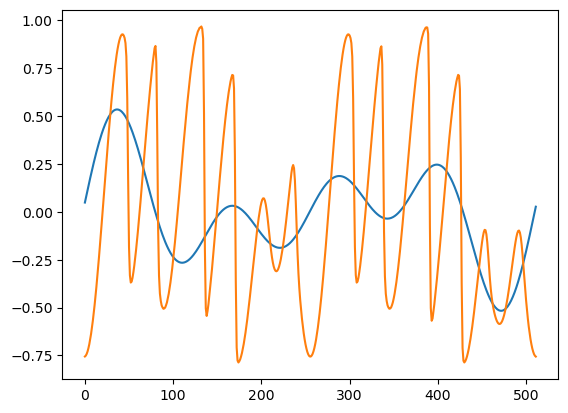

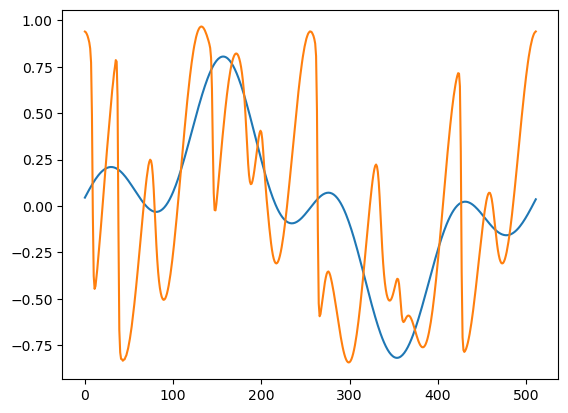

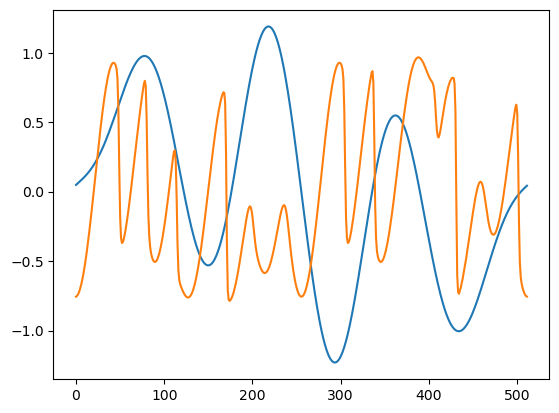

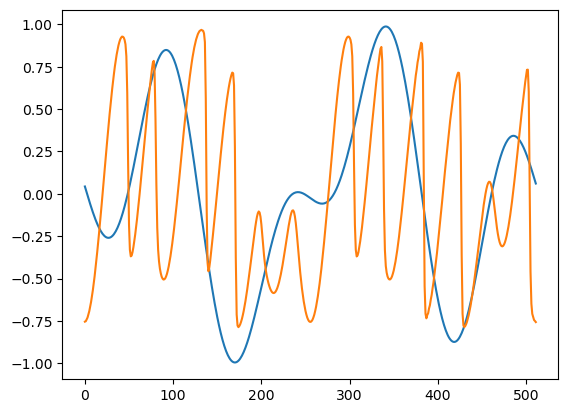

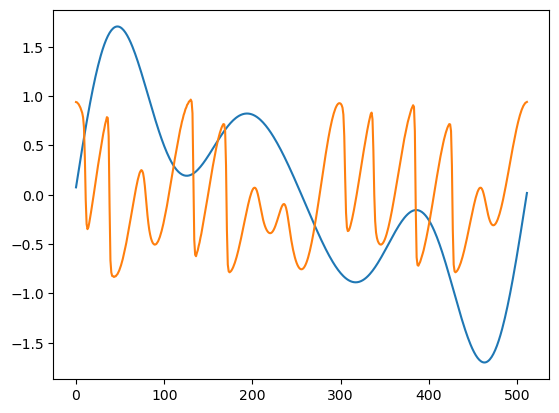

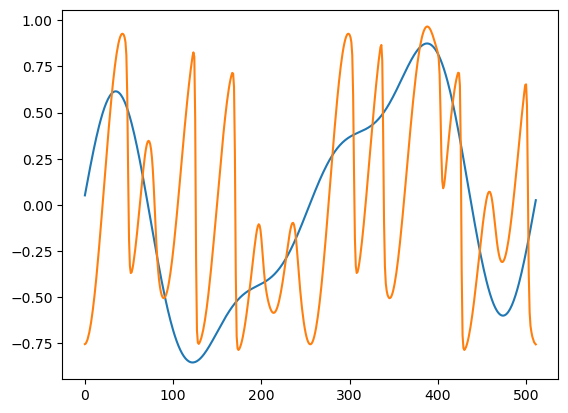

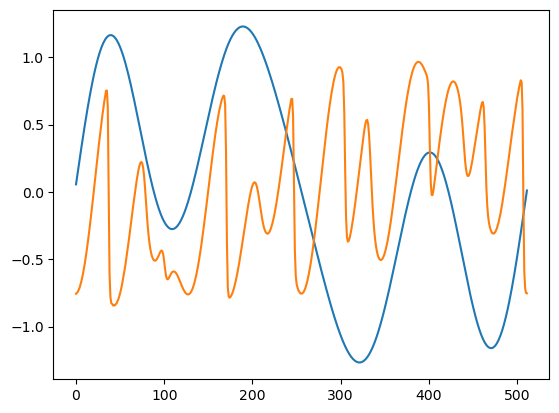

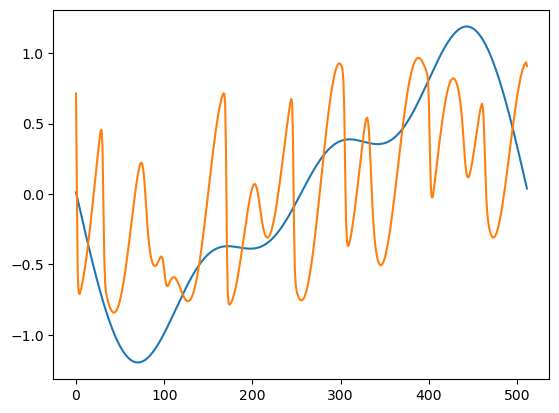

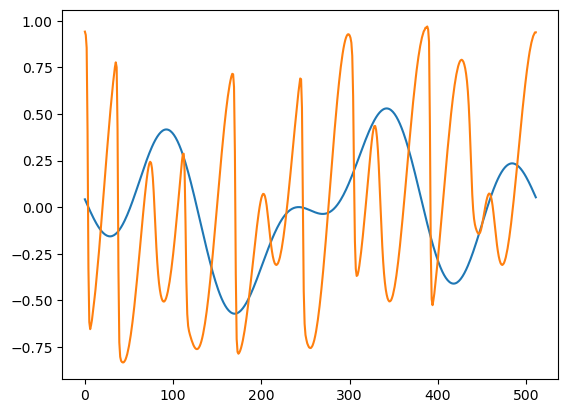

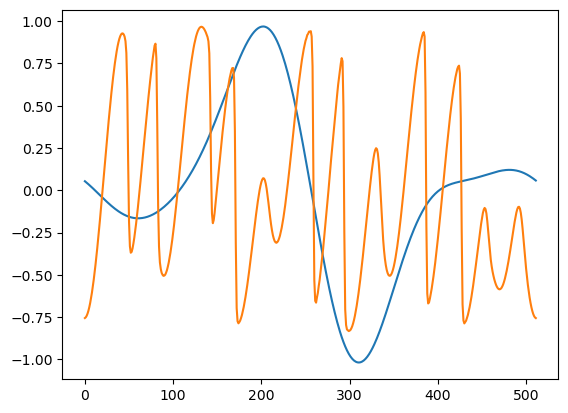

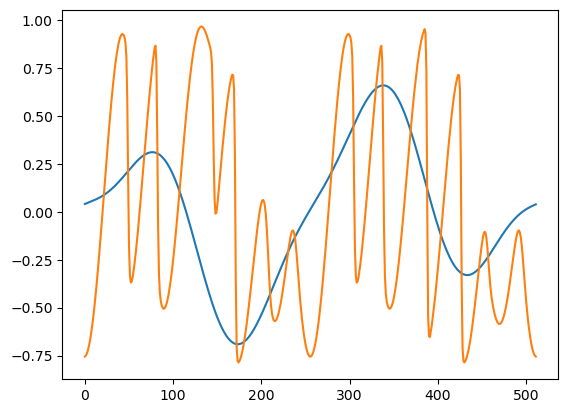

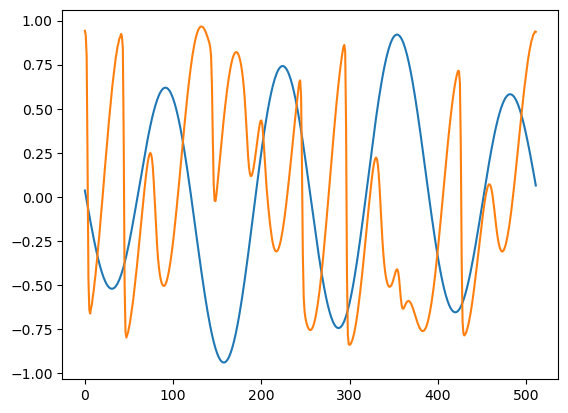

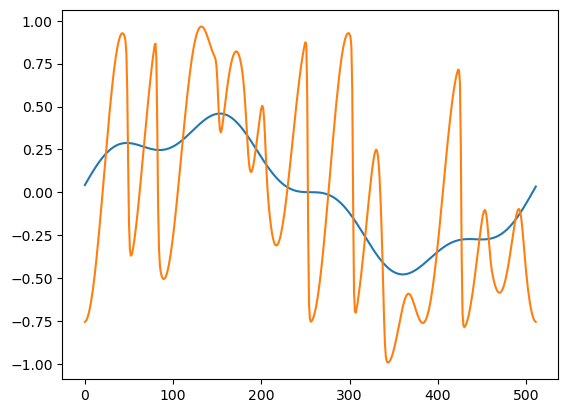

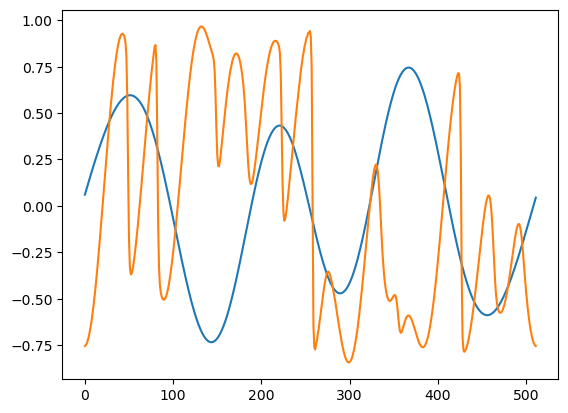

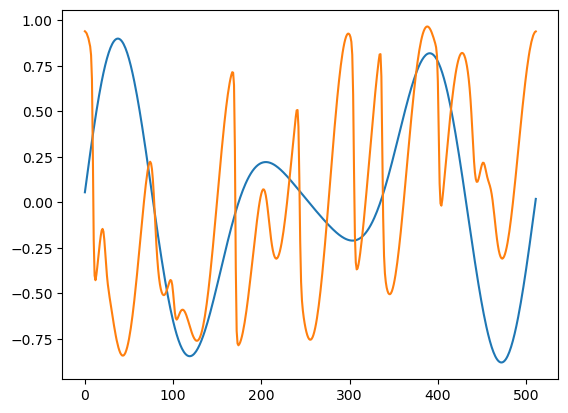

In [9]:
for i in range(0, real_space_trajectory.shape[0], 100):
    plt.figure()
    plt.plot(u0[i])
    plt.plot(real_space_trajectory[i,-1])

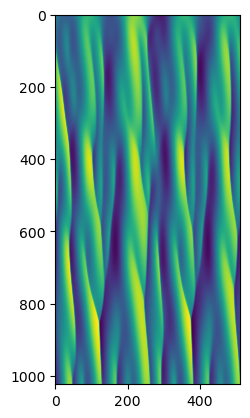

In [14]:
plt.imshow(real_space_trajectory[10])

In [15]:
real_space_trajectory.shape

(1475, 1024, 512)